This Jupyter notebook demonstrates the functionality of `phase.py` in an example phase retrieval routine. The data used here is a sample of real measurements.

In [1]:
%pylab inline
from mpl_toolkits.axes_grid1 import ImageGrid
import scipy.optimize as op
from phase import *

def imshow_grid(imgs, frac=1., clims=None):
    """A wrapper to conveniently display zoomed images in a grid."""
    n = len(imgs)
    fig = figure(figsize=(4*n, 3))
    img_grid = ImageGrid(fig, 111, nrows_ncols=(1, n), axes_pad=.75, cbar_mode='each', cbar_pad='5%')
    for i, (ax, cbar, img) in enumerate(zip(img_grid, img_grid.cbar_axes, imgs)):
        N = img.shape[0] / 2.
        M = img.shape[1] / 2.
        im = ax.imshow(img, extent=(-M, M, N, -N), interpolation='nearest')
        ax.set_xlim(-frac*M, frac*M)
        ax.set_ylim(-frac*N, frac*N)
        if (clims is not None) and (clims[i] is not None):
            im.set_clim(clims[i])
        cbar.colorbar(im)

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\skcuda\cublas.py:272: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


## Estimating the focal plane position
Defocused pinhole images are loaded from a sample data file. The function `analyze_peaks` provides normalized peak intensities, which are then used to fit a $\mathrm{sinc}^2$ function and estimate the focal plane location. Images in the file `focus.tif` were taken with a 1 mm spacing.

In [2]:
stack = tifffile.imread('demo_data.tif')
Z = arange(len(stack))   # 1 mm spacing
p, v = analyze_peaks(stack, 32, 16, index=Z)

parameters:

          x0        y0           amp           bg     tot power  norm amp
0   743.7500  802.5625   8734.609858  1288.228135  2.080772e+06  0.004198
1   744.5625  801.3750  13567.498916  1280.330212  2.015616e+06  0.006731
2   745.0625  799.9375  17905.342113  1315.006101  1.900358e+06  0.009422
3   745.3125  798.3125  22460.223761  1309.819521  1.820623e+06  0.012337
4   746.0000  797.0000  26710.770890  1225.229110  1.782164e+06  0.014988
5   746.2500  795.7500  30114.841976  1222.129575  1.754684e+06  0.017163
6   748.0000  793.9375  34062.702466  1224.909355  1.774517e+06  0.019195
7   750.0000  791.9375  37400.810933  1230.678269  1.831685e+06  0.020419
8   753.8750  791.3750  38103.130821  1258.374553  1.833669e+06  0.020780
9   751.1250  788.6875  38468.059651  1240.726324  1.854659e+06  0.020741
10  751.5625  787.3750  35592.670366  1238.001921  1.827873e+06  0.019472
11  752.1250  785.6250  33596.700080  1238.260642  1.883573e+06  0.017837
12  752.5000  784.1875  2

In [3]:
def sinc2(x, A, a, x0, B):
    """sinc^2 function for fitting to through-focus intensities."""
    return A * sinc(a * (x - x0)) ** 2 + B

A = 0.0205277274807 +/- 0.00135145818573
a = 0.0738771692898 +/- 0.00425884835804
x0 = 8.36815567935 +/- 0.0510768670719
B = 0.000257239463949 +/- 0.0014379486148


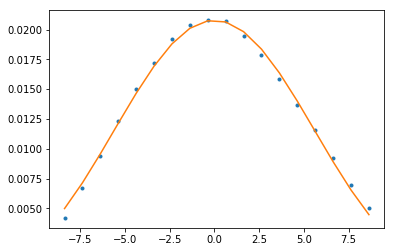

In [4]:
pfit, cfit = op.curve_fit(sinc2, Z, p['norm amp'].astype(float64), p0=(2e-2, .5e-3, (Z[0] + Z[-1]) / 2., 0.))
plt.plot(Z - pfit[2], p['norm amp'], '.')
plt.plot(Z - pfit[2], sinc2(Z, *pfit), '-')
for pname, pval, sval in zip(('A', 'a', 'x0', 'B'), pfit, np.sqrt(np.diag(cfit))):
    print(pname, '=', pval, '+/-', sval)

## Preparing images
Images are cropped to the specified size, each frame is centered at the maximum. Then, backgrounds are subtracted and images are normalized. A square root of each of them is taken to get complex amplitudes.

In [5]:
### Some physical quantities and settings are defined here.
dx = 6.8         # Pixel size [um]
z0 = 473000./dx  # Distance to the exit pupil [px]
wl = .766/dx     # Wavelength [px]
N = 256          # Image width [px]
n = 4            # Number of images to be used in a single optimization
#tr = Transforms(N, n-1, 2)  # Preparing FFTs.

In [6]:
# Transforming distances to values in pixels 
# relative to the focal plane position.
Z = (Z - pfit[2]) * 1e+3 / dx     
F = np.zeros((len(stack), N, N), dtype=np.float64)
for i, page in enumerate(stack):
    img = crop(page, p.loc[i,'x0'], p.loc[i,'y0'], s=N).astype(complex128)
    img = sqrt((img - p.loc[i,'bg']) / p.loc[i,'tot power'])
    # Conserving the zero-mean noise to avoid bias. 
    # Negative values in amplitudes are allowed.
    F[i] = img.real - img.imag

Picking 4 images for optimization, including the master plane determined by index `j`.

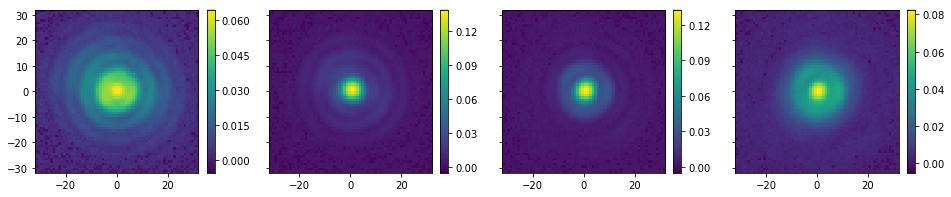

In [7]:
idx = np.array([0, 6, 11, 16])
imshow_grid(F[idx], frac=.25)

## Phase retrieval
Phase in the master plane is estimated via non-linear optimization. The optimization routine starts with random uniform phase. The L-BFGS method is used to minimize the error metric.

In [8]:
zj = Z[idx[0]]
zk = Z[idx[1:]]
Fj = F[idx[0]]
Fk = F[idx[1:]]
#errf = Errf(zj, zk, Fj, Fk, wl)
#errf = Errf_FFTW(zj, zk, Fj, Fk, wl)
errf = Errf_CUDA(zj, zk, Fj, Fk, wl)

In [9]:
ph0 = 2. * pi * (rand(N**2) - .5)
niter = [0]
nout = 50
def print_conv_info(ph):
    if not niter[0]%nout:
        E, dE = errf(ph)
        print('%4d\t%10.4e  %10.4e' % (niter[0], E, abs(dE).max()))
    niter[0] += 1
              
opt_ph = op.minimize(errf, x0=ph0, method='L-BFGS-B', jac=True, options={'maxiter':500}, callback=print_conv_info)

C:\Users\Mirek\Desktop\phase_ret3\phase.py:402: UserWarning: Setting array from one with different shape.
  self.ph.set(ph)


   0	5.1478e+00  2.0997e-02
  50	1.6659e+00  2.3417e-03
 100	1.3702e+00  1.1056e-03
 150	1.2574e+00  7.2551e-04
 200	1.2023e+00  9.9485e-04
 250	1.1689e+00  1.3072e-03
 300	1.1470e+00  6.2234e-04
 350	1.1317e+00  1.4324e-03
 400	1.1203e+00  3.4609e-04
 450	1.1117e+00  8.2694e-04
 500	1.1051e+00  6.0252e-04


Phase in the master plane is obtained directly from the optimization algorithm.

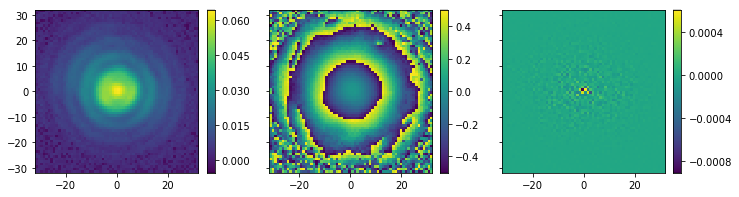

In [11]:
ph = fftshift(opt_ph.x.reshape((N,N)))
ph_jac = fftshift(opt_ph.jac.reshape((N,N)))
# This wraps the phase, making it easier to display on a graph.
P = np.exp(1.j*ph)  
imshow_grid((Fj, angle(P)/2./pi, ph_jac), frac=.25)

**Left:** master plane amplitude. **Center:** reconstructed phase in wavelengths. **Right:** gradient after the last iteration.

ASP to the focal plane and backward Fraunhofer diffraction to the exit pupil yield the exit pupil field, whose complex phase corresponds to the wavefront aberration.

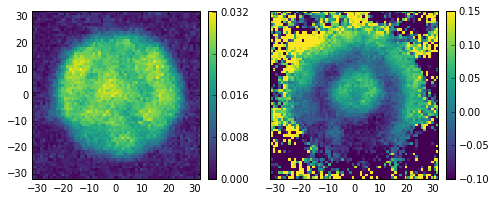

In [11]:
G0 = tr.fraun(tr.asp(F[j] * P, -Z[j], wl), -z0, wl)
# This roughly subtracts the piston, better for displaying.
G0 *= np.exp(-1.j * np.angle(np.sum(G0)))
imshow_grid((np.abs(G0), np.angle(G0)/2./np.pi), 
            frac=.25, clims=(None, (-.1,.15)))

**Left:** pupil field amplitude. **Right:** phase in wavelengths, i.e. the wavefront error.

## Pupil radius and location

A top-hat function representing the circular opening of the exit pupil is fitted. This allows to extract the pupil radius and a spatial shift due to phase tilts in the focal plane.

In [12]:
def fit_circ((A, B, dx, dy, a), img):
    circ = circle(N/2+dx, N/2+dy, a, N)*A + B
    return (circ - img).ravel()

A = 0.019706217439
B = 0.00226400245599
dx = 0.0952255377025
dy = -0.0481228115257
a = 24.0000145875


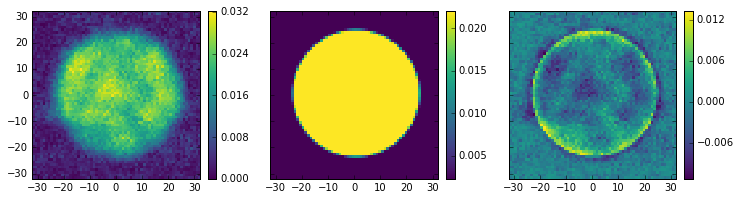

In [13]:
opt_circ = op.leastsq(fit_circ, (abs(G0).max(), 0., 0., 0., 30), 
                      args=(abs(G0),), full_output=True)
res_circ = opt_circ[2]['fvec'].reshape((N,N))  # residuals
imshow_grid((abs(G0), abs(G0)+res_circ, res_circ), frac=.25)
for pname, p in zip(('A', 'B', 'dx', 'dy', 'a'), opt_circ[0]):
    print pname, '=', p
a = opt_circ[0][-1]

**Left:** exit pupil amplitude. **Center:** the fitted top-hat. **Right:** fit residuals.

The fitted pupil location is used to correct phase tilts in the focal plane. Reconstruction is then repeated, resulting in the pupil being centered. This may not be necessary in this case, but in two-image reconstructions pupil shifts may be significantly larger.

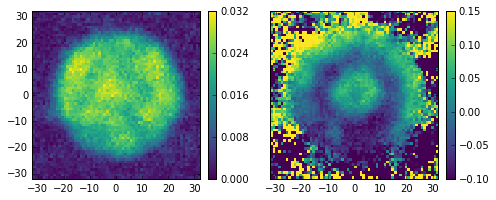

In [14]:
# This is a Fourier shift.
S = tr.fftshift(np.exp(2.j * np.pi * (tr.x*opt_circ[0][2] 
                                      + tr.y*opt_circ[0][3]) / N))
G0 = tr.fraun(tr.asp(F[j] * P, -Z[j], wl) * S, -z0, wl)
G0 *= np.exp(-1.j * np.angle(np.sum(G0)))
imshow_grid((np.abs(G0), np.angle(G0)/2./np.pi), 
            frac=.25, clims=(None, (-.1,.15)))

## Extracting Zernike polynomial expansion coefficients
The RMS wavefront error is calculated from the coefficients:  
$W_\mathrm{RMS} = \sqrt{\sum_{j=4}^{j_\mathrm{max}} c_j^2}$,  
starting from $c_4$, since piston and tilts do not represent true aberrations.  

This allows to approximate the Strehl ratio: $S\approx e^{-(2\pi W_\mathrm{RMS})^2}$.  
The object space Airy disk radius in um is calculated from the fitted pupil aperture radius and known magnification.

Wrms = 0.0358645895004
S = 0.950487891662
r0 = 0.787283032748


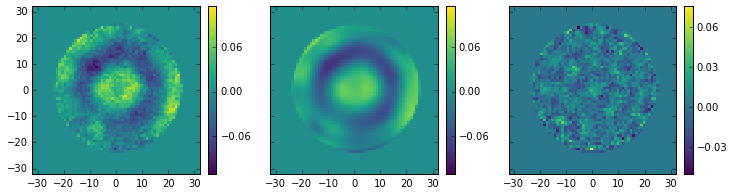

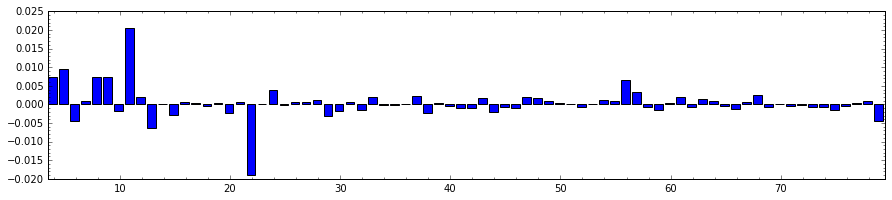

In [15]:
jmax = 79
zern = Zernike(jmax, a, N)
W0 = np.angle(G0)/2./np.pi  # the original wavefront
C = zern.fit(np.angle(G0)/2./np.pi, jmax)
# Setting to zero outside the pupil, ignoring piston and tilts.
W = zern(np.concatenate(((0,0,0), C[3:]))) * zern.R  
G0 *= np.exp(-2.j*np.pi * zern(C[:3])) # Removing piston and tilts.
W0 = np.angle(G0)/2./np.pi * zern.R

# Wavefronts set to zero outside the pupil
imshow_grid((W0, W, W - W0), frac=.25, 
            clims=((W0.min(),W0.max()),(W0.min(),W0.max()),None)) 
plt.figure(figsize=(15,3))
plt.bar(np.arange(3,jmax)+.5, C[3:])
plt.xlim(3.5, jmax+.5)
plt.minorticks_on()

Wrms = np.sqrt(np.sum(C[3:]**2))
Strehl = np.exp(-(2. * np.pi * Wrms)**2)
r0 = .61*N/a * dx / 56.20
print 'Wrms =', Wrms
print 'S =', Strehl
print 'r0 =', r0

**Left:** the original wavefront with piston and tilts removed. **Center:** Zernike fit. **Right:** fit residuals. Phase in wavelengths, set to zero outside the pupil.  
**Bottom:** expansion coefficients.